In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
zinc250k = pd.read_csv("raw/zinc250k_ions_removed_properties.csv")
print("Ion removed:", len(zinc250k))

zinc250k = zinc250k[~zinc250k["SMILES"].str.contains("\+")]                                                                                                                                                    
zinc250k = zinc250k[~zinc250k["SMILES"].str.contains("\[nH\]")]   
print("Zero formal chage + no [nH]:", len(zinc250k))

Ion removed: 179892


3.000910000000001
1<x<2: 25881
2.0<x<2.1: 4107
4<x<5: 28117


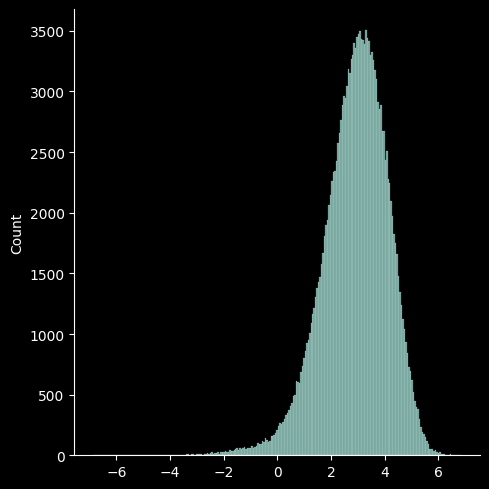

In [6]:
logp_data = zinc250k["LOGP"].values

print(np.median(logp_data))

print("1<x<2:", np.sum((logp_data<2)&(logp_data>1)))
print("2.0<x<2.1:", np.sum((logp_data<2.1)&(logp_data>2.0)))
print("4<x<5:", np.sum((logp_data<5)&(logp_data>4)))

sns.displot(logp_data)

# sample data whose distribution is to be Gaussian

In [7]:
class Gaussian:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def __call__(self, x):
        return np.exp(-0.5*((x-self.mean)/self.std)**2)/(self.std*np.sqrt(2*np.pi))
    
    def __repr__(self):
        return f"Gaussian(mean={self.mean}, std={self.std})"

In [8]:
avg1, avg2 = 2, 4
std1, std2 = 0.5, 0.5

gaussian1, gaussian2 = Gaussian(avg1, std1), Gaussian(avg2, std2)
print(gaussian1)
print(gaussian2)
print(gaussian1(3), gaussian2(5))

Gaussian(mean=2, std=0.5)
Gaussian(mean=4, std=0.5)
0.1079819330263761 0.1079819330263761


In [19]:
num_total_data = 30081
num_bins = 60
sigma_range = 3     # -3sigma to 3sigma

bin_intervals = np.linspace(-1*sigma_range, sigma_range, num_bins+1)
bin_intervals = np.stack([bin_intervals[:-1], bin_intervals[1:]], axis=0)

bin_intervals1 = avg1 + std1*bin_intervals  # [2,50]
bin_intervals2 = avg2 + std2*bin_intervals  # [2,50]
print(bin_intervals1[0])

densities1 = gaussian1(bin_intervals1.mean(axis=0))
densities2 = gaussian2(bin_intervals2.mean(axis=0))

densities1 = densities1 * 2 * sigma_range * std1 / num_bins
densities2 = densities2 * 2 * sigma_range * std2 / num_bins
print(densities1.sum())
print(densities2.sum())

occurences1 = np.round(densities1 * num_total_data).astype(int)
occurences2 = np.round(densities2 * num_total_data).astype(int)
print(occurences1.sum())
print(occurences2.sum())

[0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15
 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85
 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55
 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15 3.2  3.25
 3.3  3.35 3.4  3.45]
0.9973112641735729
0.9973112641735727
30002
30002


In [20]:
from tqdm import tqdm

retrieved_dict1 = {idx:[] for idx in range(num_bins)}
retrieved_dict2 = {idx:[] for idx in range(num_bins)}

for _, row in tqdm(zinc250k.iterrows()):
    smi, logp = row["SMILES"], row["LOGP"]

    # 1. check on Gaussian1
    if logp < avg1 - sigma_range*std1 or logp > avg1 + sigma_range*std1:        # not target
        pass
    else:
        bin_idx = int((logp-avg1)/std1 * num_bins / (2*sigma_range)) + int(num_bins/2)
        if logp < avg1:
            bin_idx -= 1
        if bin_idx == -1:
            bin_idx = 0
        if len(retrieved_dict1[bin_idx]) >= occurences1[bin_idx]:                # fully occupied
            pass
        else:
            retrieved_dict1[bin_idx].append(row)
            continue
            
    # 2. check on Gaussian2
    if logp < avg2 - sigma_range*std2 or logp > avg2 + sigma_range*std2:        # not target
        pass
    else:
        bin_idx = int((logp-avg2)/std2 * num_bins / (2*sigma_range)) + int(num_bins/2)
        if logp < avg2:
            bin_idx -= 1
        if bin_idx == -1:
            bin_idx = 0
        if len(retrieved_dict2[bin_idx]) >= occurences2[bin_idx]:                # fully occupied
            pass
        else:
            retrieved_dict2[bin_idx].append(row)
            continue
            

179892it [00:08, 21748.02it/s]


In [21]:
retrieved_num1 = np.array([len(retrieved_dict1[idx]) for idx in range(num_bins)])
retrieved_num2 = np.array([len(retrieved_dict2[idx]) for idx in range(num_bins)])

print(retrieved_num1)
print(retrieved_num2)

print(retrieved_num1.sum())
print(retrieved_num2.sum())

[  15   21   27   36   46   60   76   95  119  147  179  217  260  308
  361  419  482  549  619  692  764  836  906  972 1032 1085 1129 1163
 1187 1199 1199 1187 1163 1129 1085 1032  972  906  836  764  692  619
  549  482  419  361  308  260  217  179  147  119   95   76   60   46
   36   27   21   15]
[  15   21   27   36   46   60   76   95  119  147  179  217  260  308
  361  419  482  549  619  692  764  836  906  972 1032 1085 1129 1163
 1187 1199 1199 1187 1163 1129 1085 1032  972  906  836  764  692  619
  549  482  419  361  308  260  217  179  147  119   95   76   60   46
   36   27   21   15]
30002
30002


<Axes: >

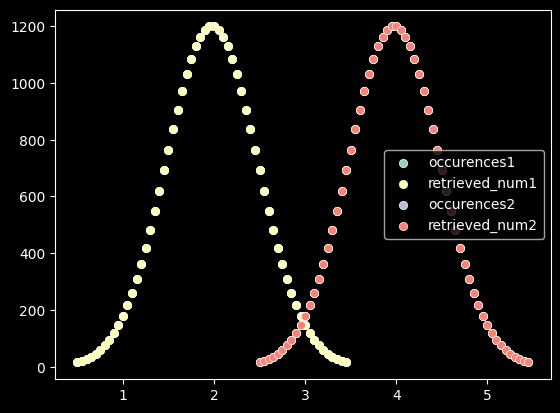

In [22]:
sns.scatterplot(x=bin_intervals1[0], y=(occurences1), label="occurences1")
sns.scatterplot(x=bin_intervals1[0], y=(retrieved_num1), label="retrieved_num1")

sns.scatterplot(x=bin_intervals2[0], y=(occurences2), label="occurences2")
sns.scatterplot(x=bin_intervals2[0], y=(retrieved_num2), label="retrieved_num2")

<Axes: ylabel='Count'>

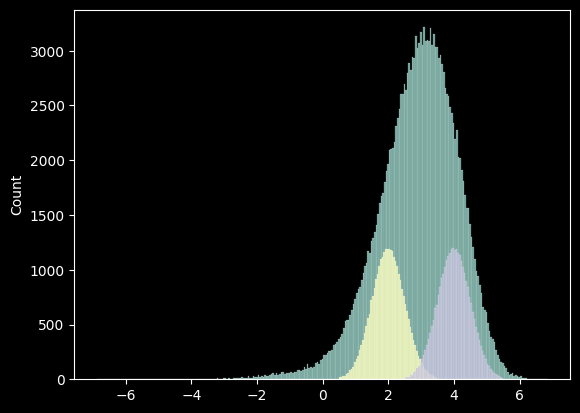

In [23]:
retrieved_df1 = pd.concat(retrieved_dict1[0], axis=1).T
for i in range(1, num_bins):
    retrieved_df1 = pd.concat([retrieved_df1, pd.concat(retrieved_dict1[i], axis=1).T], axis=0)
# print(retrieved_df1)

retrieved_df2 = pd.concat(retrieved_dict2[0], axis=1).T
for i in range(1, num_bins):
    retrieved_df2 = pd.concat([retrieved_df2, pd.concat(retrieved_dict2[i], axis=1).T], axis=0)
# print(retrieved_df2)

sns.histplot(logp_data, label="original", binwidth=0.05)
sns.histplot(retrieved_df1["LOGP"].values, label="retrieved1", binwidth=0.05)
sns.histplot(retrieved_df2["LOGP"].values, label="retrieved2", binwidth=0.05)

In [24]:
print(retrieved_df1.head())
print(len(retrieved_df1))
print(len(retrieved_df2))

                                                SMILES   TPSA       QED  \
325  Cc1ccc(F)c(O[C@H]2CC[C@]([NH2+]C(C)C)(C(=O)[O-...  65.97  0.861323   
367                       OCc1cn(-c2ccc3c(c2)OCCO3)nn1   69.4  0.818997   
377                 Cn1ncc2c1CCC[C@H]2NC(=O)CN1CCCC1=O  67.23  0.875725   
493            CN1CCO[C@H](CN(C)c2cccc(/C(N)=N/O)c2)C1  74.32  0.363989   
984     CNC(=O)c1cn[nH]c1[C@]1(C)CCCN(C(=O)Cn2cccn2)C1  95.91  0.855358   

          SAS     PLOGP     LOGP  
325  4.340509 -2.721756  0.52592  
367  2.363995 -0.347069   0.5308  
377   2.93429 -1.027574   0.5361  
493  3.059665 -1.169763   0.5479  
984  3.428911 -1.614014   0.5461  
30002
30002


## 1. Random pairing

In [25]:
# random shuffle dataframe row order
np.random.seed(42)
_retrieved_df1 = retrieved_df1.sample(frac=1).reset_index(drop=True)
_retrieved_df2 = retrieved_df2.sample(frac=1).reset_index(drop=True)

_retrieved_df1.to_csv("zinc250k_logp_retrieved1.csv", index=False)
_retrieved_df2.to_csv("zinc250k_logp_retrieved2.csv", index=False)

In [ ]:
data_to_save = { 
    "REF-SMI": _retrieved_df1["SMILES"].values,
    "PRB-SMI": _retrieved_df2["SMILES"].values,
    "REF-TPSA": _retrieved_df1["TPSA"].values,
    "PRB-TPSA": _retrieved_df2["TPSA"].values,
    "REF-QED": _retrieved_df1["QED"].values,
    "PRB-QED": _retrieved_df2["QED"].values,
    "REF-SAS": _retrieved_df1["SAS"].values,
    "PRB-SAS": _retrieved_df2["SAS"].values,
    "REF-PLOGP": _retrieved_df1["PLOGP"].values,
    "PRB-PLOGP": _retrieved_df2["PLOGP"].values,
    "REF-LOGP": _retrieved_df1["LOGP"].values,
    "PRB-LOGP": _retrieved_df2["LOGP"].values,
} 
data_df_to_save = pd.DataFrame(data_to_save)
data_df_to_save.to_csv("./raw/ZINC250k_logp_random_matched_2_4_no_nH.csv", index=False)